In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
import os, sys, random
import numpy as np
import PIL
from PIL import Image

from gen_utils import *
from ds import *
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
load_tfm = transforms.Compose([
    transforms.ToTensor(),
    lambda x : (x-x.min())/(x.max()-x.min())
])

In [3]:
train_set = XrayDset('../data/train/', load_tfm)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=10, shuffle=True)

test_set = XrayDset('../data/test/', load_tfm)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=10, shuffle=False)

In [4]:
class XrayResnet(torch.nn.Module):
    def __init__(self):
        super(XrayResnet, self).__init__()
        self.C1 = torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1, stride=1)
        self.model_ft = torchvision.models.resnet18()
        self.model_ft.avgpool = torch.nn.AvgPool2d(kernel_size=4, padding=0, stride=2)
        self.model_ft.fc = torch.nn.Sequential(
            torch.nn.Linear(512,256),
            torch.nn.Linear(256,2)
        )
        
    def forward(self, x):
        y = x
        y = self.C1(y)
        for lid, layer in enumerate(list(self.model_ft.children())[:9]):
            y = layer(y)
        y = y.squeeze(-1).squeeze(-1)
        y = list(self.model_ft.children())[-1](y)
        return y

# train and test loop

epoch : 0 ...
train avg loss :  0.06271755615621805
num of correct samples : 1351/2000
test avg loss :  0.07326721698045731
num of correct samples : 60/120
epoch : 1 ...
train avg loss :  0.059338306993246076
num of correct samples : 1400/2000
test avg loss :  0.0676892101764679
num of correct samples : 61/120
epoch : 2 ...
train avg loss :  0.058202858872711656
num of correct samples : 1415/2000
test avg loss :  0.12421933114528656
num of correct samples : 67/120
epoch : 3 ...
train avg loss :  0.05864578062295914
num of correct samples : 1427/2000
test avg loss :  0.06448346152901649
num of correct samples : 70/120
epoch : 4 ...
train avg loss :  0.05900446000695229
num of correct samples : 1416/2000
test avg loss :  0.07038784821828206
num of correct samples : 59/120
epoch : 5 ...
train avg loss :  0.05817401498556137
num of correct samples : 1431/2000
test avg loss :  0.08344009766976039
num of correct samples : 61/120
epoch : 6 ...
train avg loss :  0.06073811326920986
num of corr

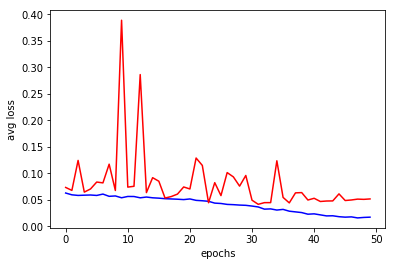

              precision    recall  f1-score   support

       No TB       0.78      0.83      0.81        60
          TB       0.82      0.77      0.79        60

   micro avg       0.80      0.80      0.80       120
   macro avg       0.80      0.80      0.80       120
weighted avg       0.80      0.80      0.80       120



In [5]:
n_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
M = XrayResnet()
M = M.to(device)
optimizer = torch.optim.Adam(M.parameters(), lr=6e-4, weight_decay=1e-2)
exp_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
criterion = torch.nn.CrossEntropyLoss()

train_loss_track = []
test_loss_track = []

for eph in range(n_epochs):
    print('epoch : {} ...'.format(eph))
    n_correct = 0
    avg_loss = 0
    n_samples = 0
    M.train()
    exp_lr_scheduler.step()
    for idx, xy in enumerate(train_loader):
        x, y = xy
        x, y = x.to(device), y.to(device)
        outputs = M(x)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        n_correct += torch.sum(preds.data == y.data)
        avg_loss += loss.item()
        n_samples += x.size(0)
    avg_loss = avg_loss/n_samples
    train_loss_track.append(avg_loss)
    print('train avg loss : ', avg_loss)
    print('num of correct samples : {}/{}'.format(n_correct, n_samples))
    
    n_correct = 0
    avg_loss = 0
    n_samples = 0
    gt_labels = []
    pred_labels = []
    M.eval()
    for idx, xy in enumerate(test_loader):
        x, y = xy
        x, y = x.cuda(), y.cuda()
        outputs = M(x)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, y)
        
        n_correct += torch.sum(preds.data == y.data)
        gt_labels += list(y.data.cpu().numpy())
        pred_labels += list(preds.data.cpu().numpy())
        avg_loss += loss.item()
        n_samples += x.size(0)
    avg_loss = avg_loss/n_samples
    test_loss_track.append(avg_loss)
    print('test avg loss : ', avg_loss)
    print('num of correct samples : {}/{}'.format(n_correct, n_samples))
    
    
plt.plot(train_loss_track, 'b')
plt.plot(test_loss_track, 'r')
plt.xlabel('epochs')
plt.ylabel('avg loss')
plt.show()

target_names = ['No TB', 'TB']
print(classification_report(gt_labels, pred_labels, target_names=target_names))

In [6]:
M

XrayResnet(
  (C1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (model_ft): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1